### Introvert/Extrovert Personality Prediction: Advanced EDA & Feature Engineering

# IMPORTS & SETUP

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


# DATA CLEANING & TYPE CONVERSION

In [4]:
def clean_data(df):
    # Handle boolean columns
    bool_cols = ['Drained_after_socializing']
    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].replace({'Yes': 1, 'No': 0, True: 1, False: 0})
    
    # Convert infinity values to NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

In [5]:
train = clean_data(train)
test = clean_data(test)

/tmp/ipykernel_13/361845854.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0, True: 1, False: 0})


# IDENTIFY NUMERICAL FEATURES

In [6]:
# Exclude non-feature columns
exclude_cols = ['id', 'Personality', 'target_num']  # Remove any non-feature columns
features = [col for col in train.columns if col not in exclude_cols]

# Select only numerical features
numerical_features = train[features].select_dtypes(include=['number']).columns.tolist()

print(f"Numerical features to plot: {numerical_features}")

Numerical features to plot: ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']


# CREATE DISTRIBUTION PLOTS

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

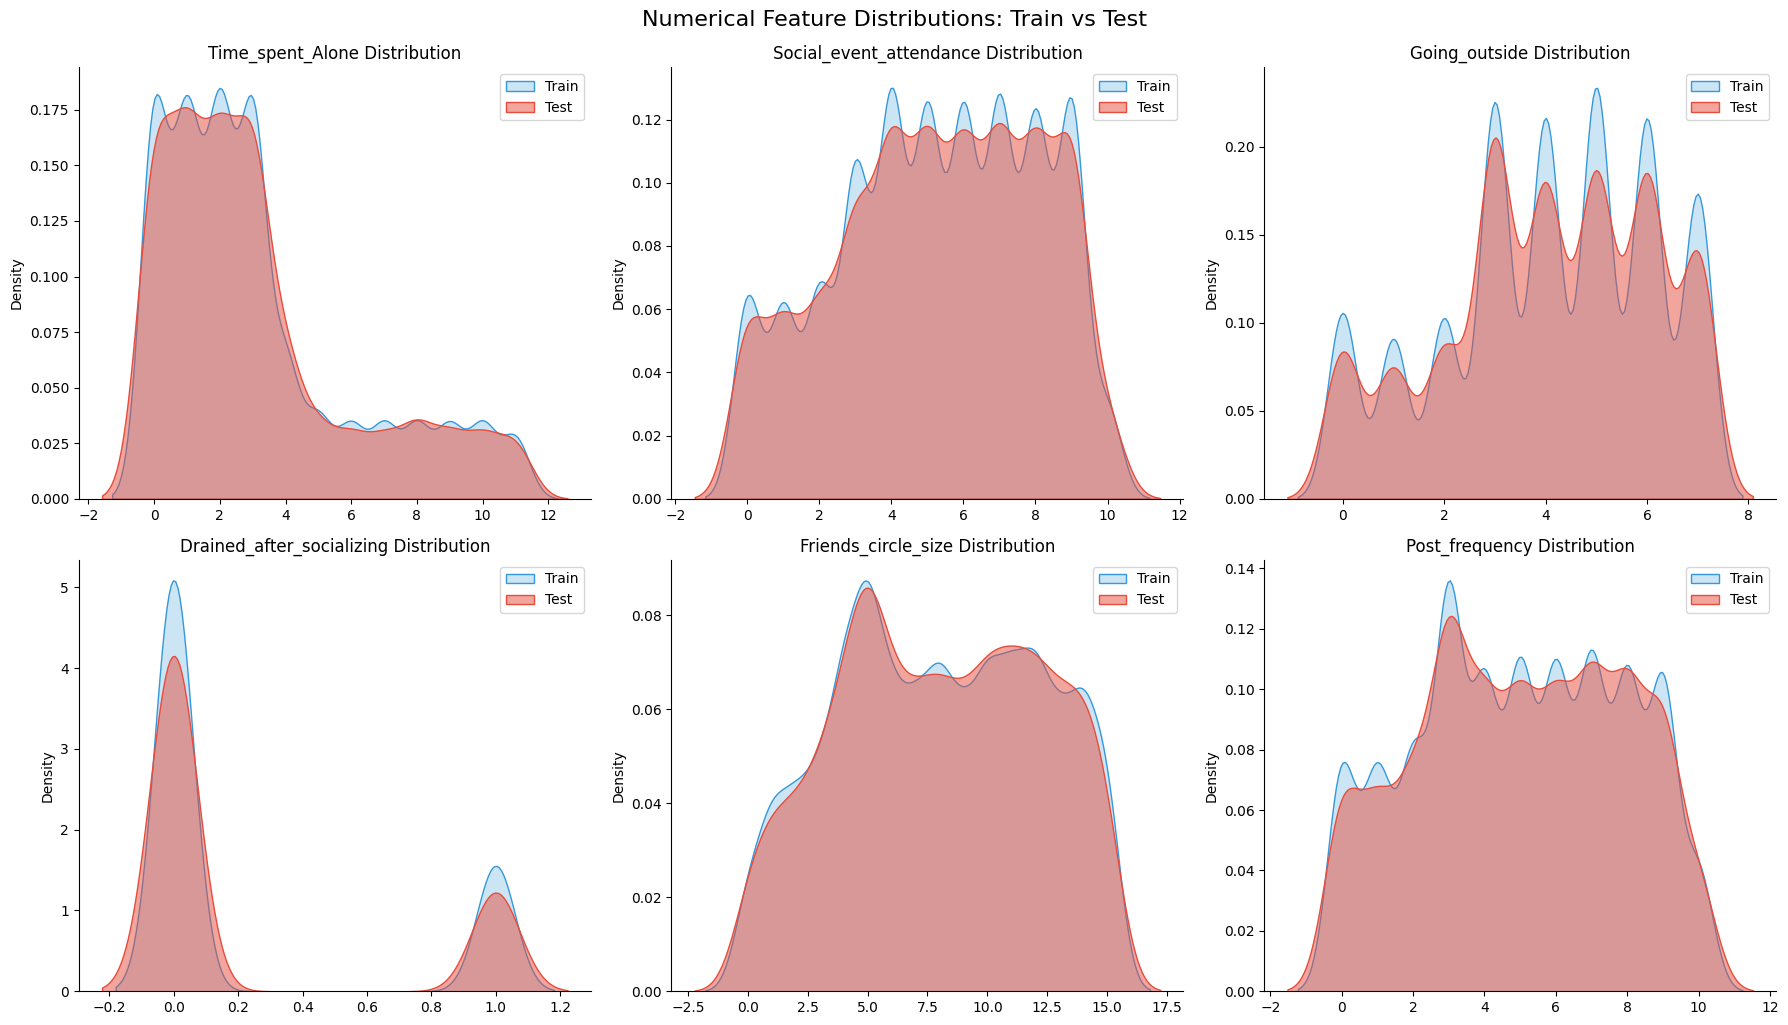

In [7]:
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols  # Round up division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()  # Flatten for easy iteration

for i, col in enumerate(numerical_features):
    try:
        # Plot train distribution
        sns.kdeplot(train[col].dropna(), ax=axes[i], 
                   color='#3498db', fill=True, label='Train')
        
        # Plot test distribution
        sns.kdeplot(test[col].dropna(), ax=axes[i], 
                   color='#e74c3c', fill=True, alpha=0.5, label='Test')
        
        # Customize plot
        axes[i].set_title(f'{col} Distribution', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].legend()
        
        # Remove top and right spines
        sns.despine(ax=axes[i])
        
    except Exception as e:
        print(f"Could not plot {col}: {str(e)}")
        axes[i].set_visible(False)

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Numerical Feature Distributions: Train vs Test', 
             fontsize=16, y=1.02)
plt.show()



# CATEGORICAL FEATURES 

In [8]:
categorical_features = train[features].select_dtypes(exclude=['number']).columns.tolist()

if categorical_features:
    print(f"\nCategorical features found: {categorical_features}")
    # Similar plotting logic for categorical features can be added here
else:
    print("\nNo categorical features found.")


Categorical features found: ['Stage_fear']


# TARGET DISTRIBUTION

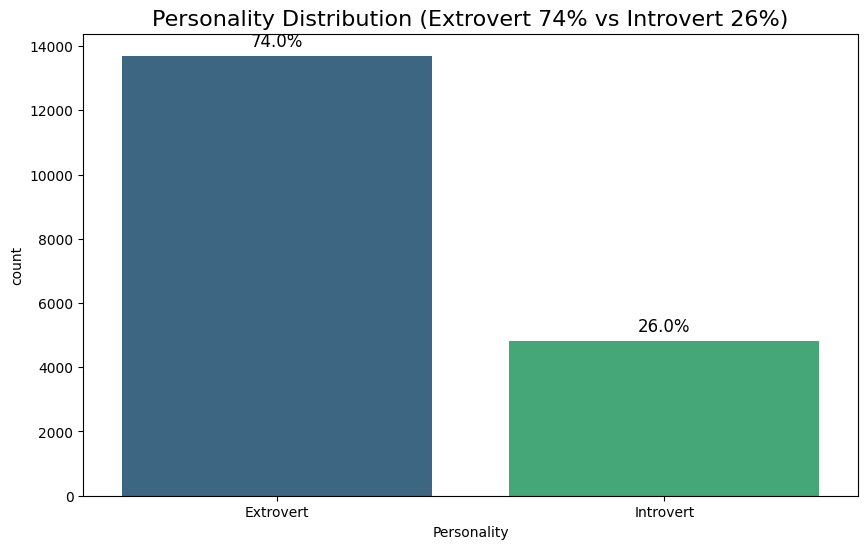

In [9]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='Personality', data=train, palette='viridis')
plt.title('Personality Distribution (Extrovert 74% vs Introvert 26%)', fontsize=16)
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(train)*100:.1f}%', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0,10), 
                textcoords='offset points', fontsize=12)
plt.show()

# MISSING VALUES

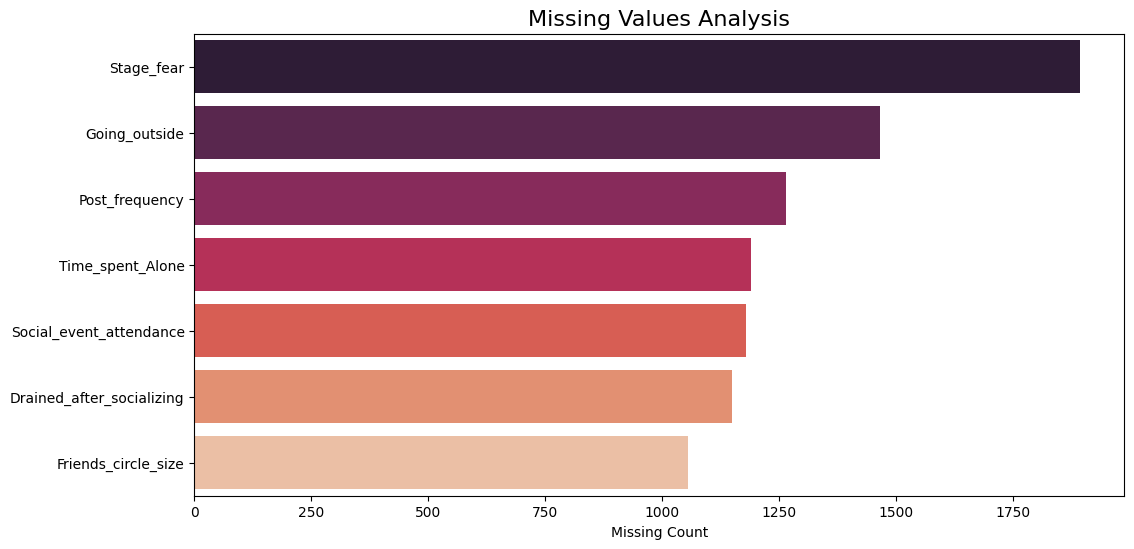

In [10]:
plt.figure(figsize=(12,6))
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
sns.barplot(x=missing.values, y=missing.index, palette='rocket')
plt.title('Missing Values Analysis', fontsize=16)
plt.xlabel('Missing Count')
plt.show()

# CORRELATION ANALYSIS

In [11]:
train['target_num'] = train['Personality'].map({'Extrovert':1, 'Introvert':0})


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


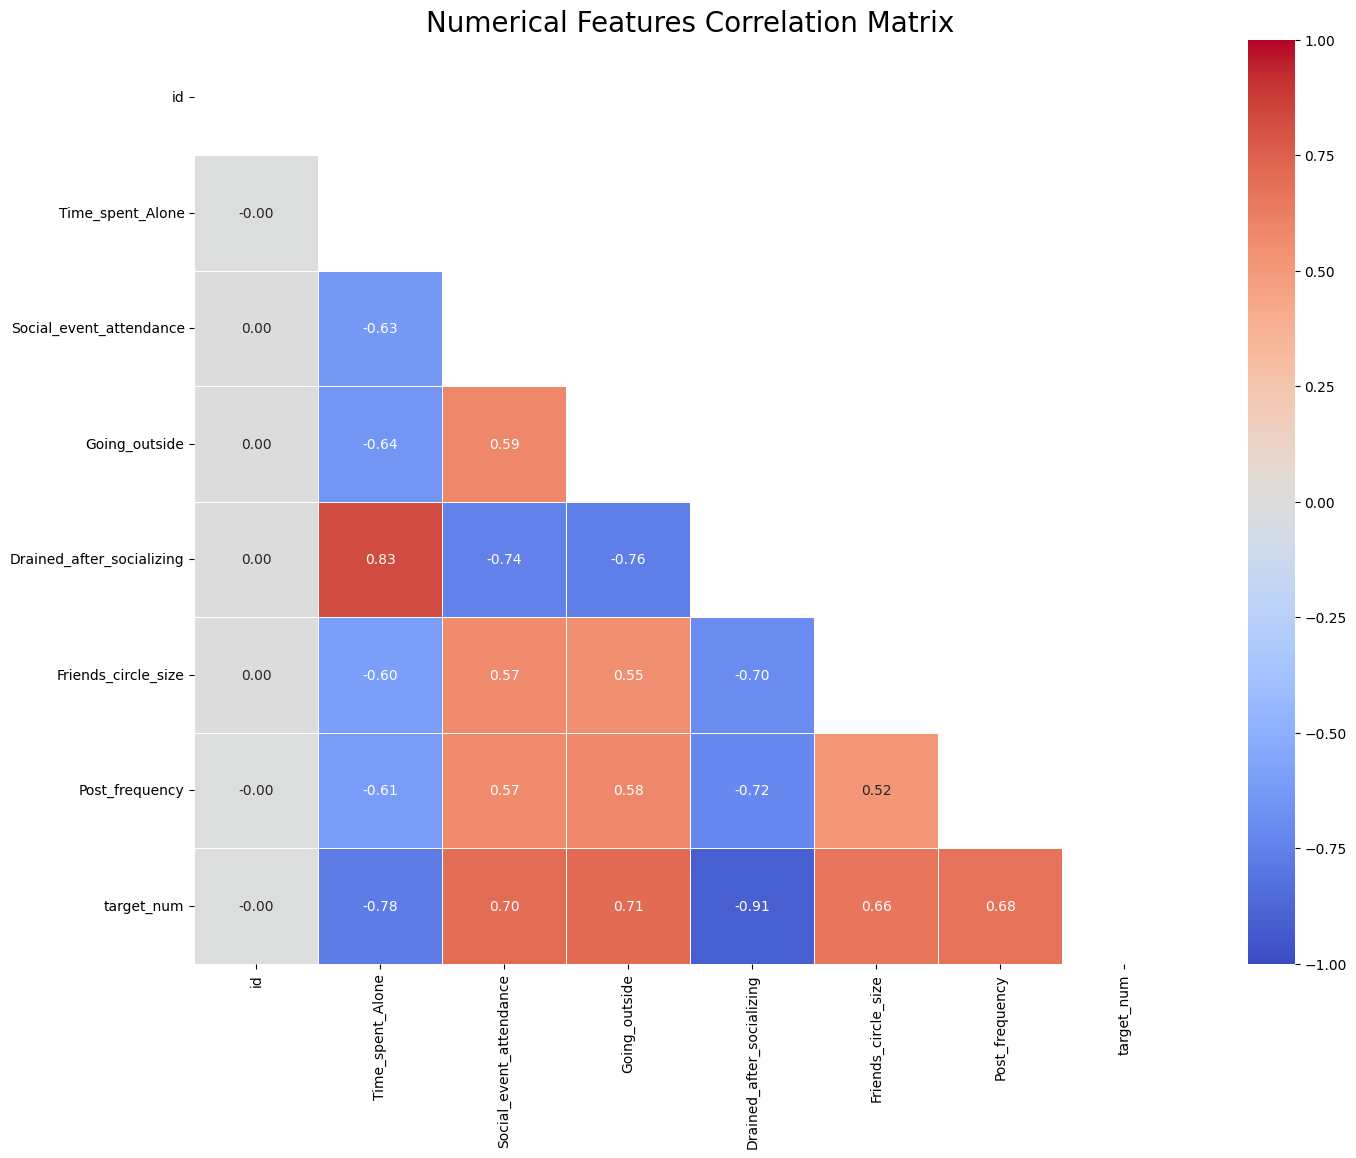

In [12]:
# Select only numerical columns for correlation
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix only for numerical columns
corr = train[numerical_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up matplotlib figure
plt.figure(figsize=(16,12))

# Generate heatmap
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5,
            vmin=-1, vmax=1)

plt.title('Numerical Features Correlation Matrix', fontsize=20)
plt.show()

## Check missing values

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
target_num                      0
dtype: int64


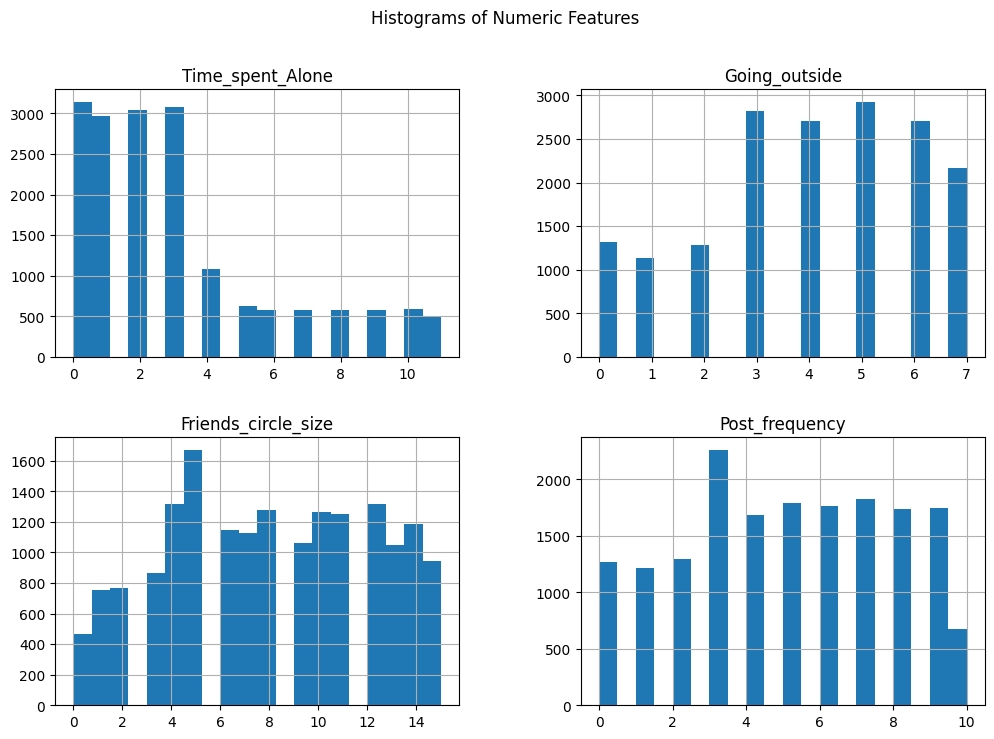

In [13]:
# Check missing values
print(train.isnull().sum())

# Histograms for numeric features
numeric_cols = ['Time_spent_Alone','Stage_fear','Going_outside','Friends_circle_size','Post_frequency']
train[numeric_cols].hist(bins=20, figsize=(12,8))
plt.suptitle("Histograms of Numeric Features")
plt.show()




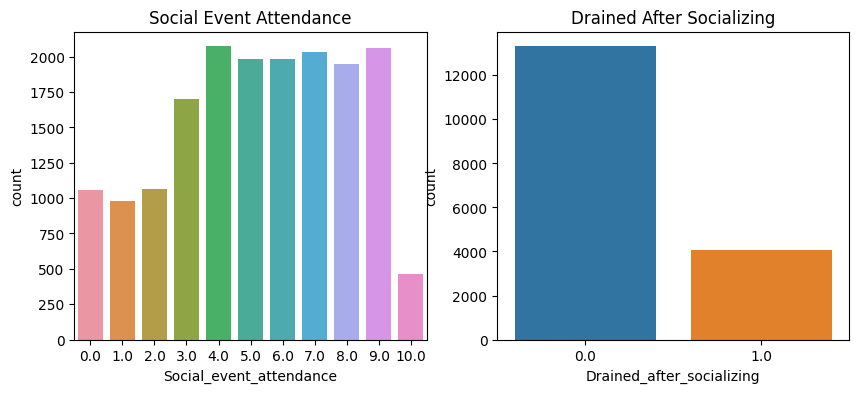

In [14]:
# Countplots for boolean/categorical features
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x='Social_event_attendance', data=train, ax=axs[0])
sns.countplot(x='Drained_after_socializing', data=train, ax=axs[1])
axs[0].set_title('Social Event Attendance')
axs[1].set_title('Drained After Socializing')
plt.show()

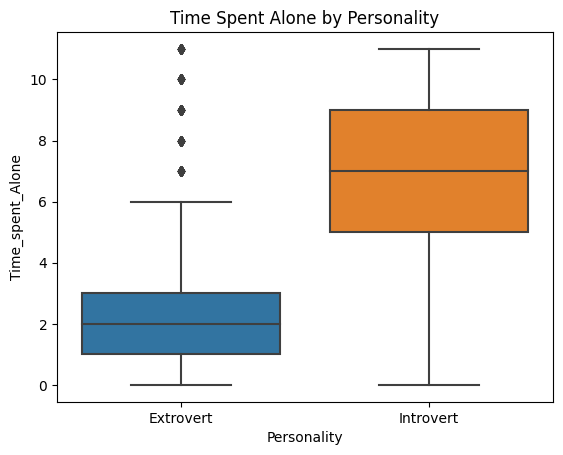

In [15]:
# Boxplot: Time_spent_Alone by Personality
sns.boxplot(x='Personality', y='Time_spent_Alone', data=train)
plt.title("Time Spent Alone by Personality")
plt.show()

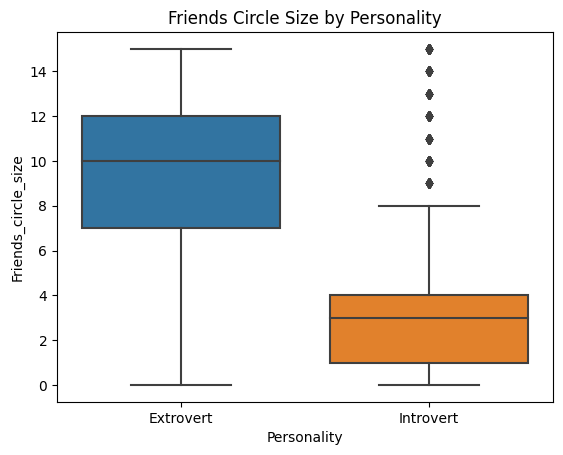

In [16]:
# Boxplot: Friends_circle_size by Personality
sns.boxplot(x='Personality', y='Friends_circle_size', data=train)
plt.title("Friends Circle Size by Personality")
plt.show()